# gwexpy TimeSeries 新機能チュートリアル

このノートブックでは、`gwpy` を拡張した `gwexpy` の `TimeSeries` クラスに追加された新しいメソッドとその使い方を解説します。

`gwexpy` は GWpy との高い互換性を維持しつつ、信号処理、統計解析、他ライブラリとの相互運用性を大幅に強化しています。

## 目次
1. [環境セットアップ](#setup)
2. [信号処理と復調 (Hilbert, Phase, Demodulation)](#signal-processing)
3. [スペクトル解析と相関 (FFT, Transfer Function, xcorr)](#spectral)
4. [統計・前処理 (Impute, Standardize, ARIMA, Hurst, Rolling)](#stats)
5. [リサンプリングと再インデックス (asfreq, resample)](#resampling)
6. [相互運用性 (Pandas, Xarray, Torch, and more)](#interop)

<a id="setup"></a>
## 1. 環境セットアップ

まずは必要なライブラリをインポートし、デモ用のサンプルデータを生成します。

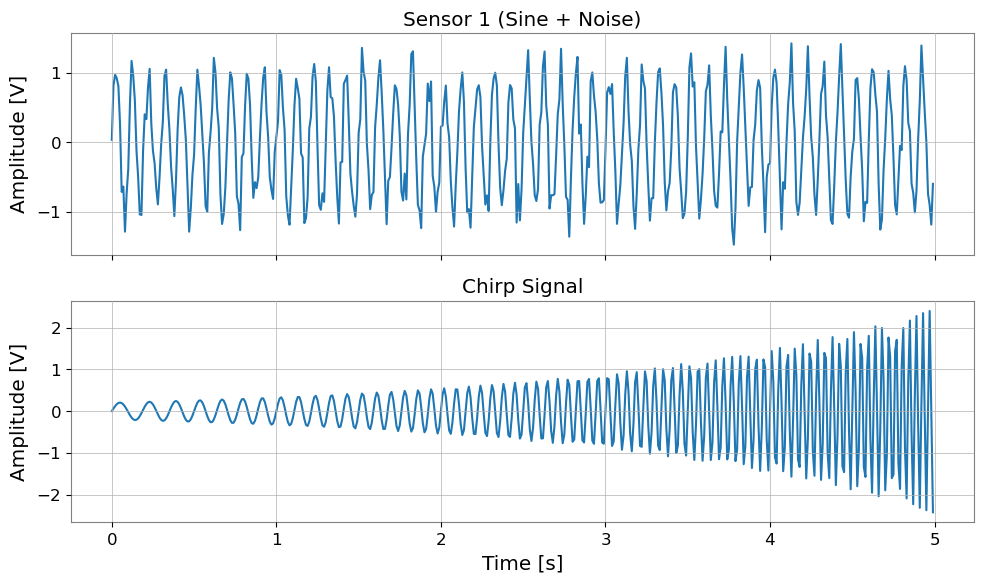

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from gwexpy.timeseries import TimeSeries
from astropy import units as u
from IPython.display import display

# サンプルデータの生成 (100Hzでサンプリングされた5秒間のデータ)
fs = 100
t = np.arange(0, 5, 1/fs)

# Sensor 1: 10Hzの正弦波 + ノイズ
data1 = np.sin(2 * np.pi * 10 * t) + 0.2 * np.random.randn(len(t))
# Sensor 2: チャープ信号 (周波数が時間とともに変化)
data2 = np.sin(2 * np.pi * (5 + 2*t) * t) * np.exp(t/2)/5

ts1 = TimeSeries(data1, sample_rate=fs, unit='V', name='Sensor 1', t0=0)
ts2 = TimeSeries(data2, sample_rate=fs, unit='V', name='Chirp Signal', t0=0)

# プロットして確認
fig, ax = plt.subplots(2, 1, figsize=(10, 6), sharex=True)
ax[0].plot(ts1)
ax[0].set_ylabel('Amplitude [V]')
ax[0].set_title('Sensor 1 (Sine + Noise)')
ax[1].plot(ts2)
ax[1].set_ylabel('Amplitude [V]')
ax[1].set_title('Chirp Signal')
plt.xlabel('Time [s]')
plt.tight_layout()
plt.show()

<a id="signal-processing"></a>
## 2. 信号処理と復調

`gwexpy` では、ヒルベルト変換や包絡線、瞬時周波数の計算、さらにロックインアンプのような復調機能が統合されています。

### ヒルベルト変換と包絡線
`analytic_signal` (または `hilbert`) と `envelope` を使用します。

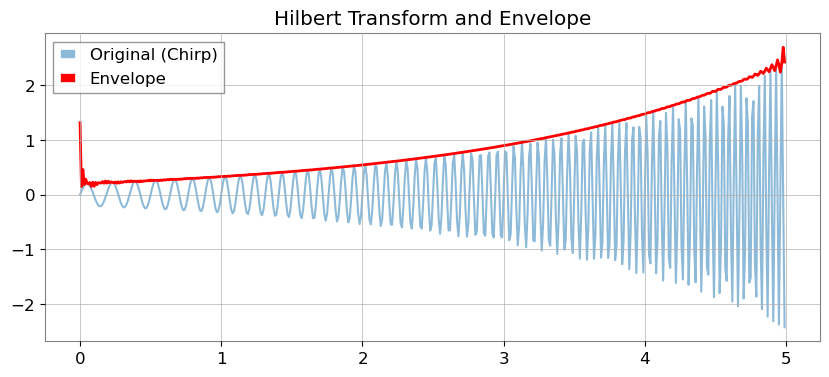

In [2]:
# 分析信号 (Analytic Signal) の計算
ts_analytic = ts2.hilbert()
# 包絡線 (Envelope) の計算
ts_env = ts2.envelope()

plt.figure(figsize=(10, 4))
plt.plot(ts2, label='Original (Chirp)', alpha=0.5)
plt.plot(ts_env, label='Envelope', color='red', linewidth=2)
plt.legend()
plt.title('Hilbert Transform and Envelope')
plt.show()

### 瞬時位相と瞬時周波数
`instantaneous_phase` と `instantaneous_frequency` を使用します。位相のアンラップ (`unwrap`) や度の単位 (`deg`) も指定可能です。

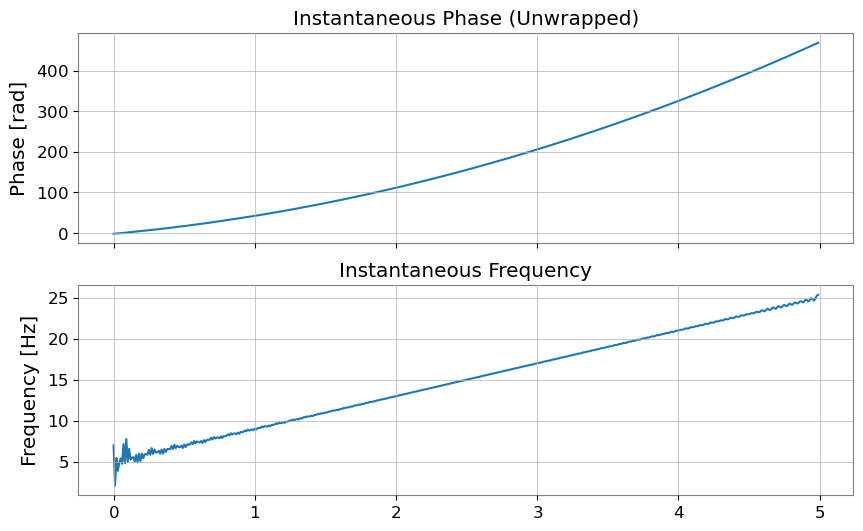

In [3]:
# 瞬時位相 (unwrap=True で位相跳びを解消)
phase_rad = ts2.instantaneous_phase(unwrap=True)
phase_deg = ts2.unwrap_phase(deg=True) # unwrap_phase は alias

# 瞬時周波数
freq = ts2.instantaneous_frequency()

fig, ax = plt.subplots(2, 1, figsize=(10, 6), sharex=True)
ax[0].plot(phase_rad)
ax[0].set_ylabel('Phase [rad]')
ax[0].set_title('Instantaneous Phase (Unwrapped)')
ax[1].plot(freq)
ax[1].set_ylabel('Frequency [Hz]')
ax[1].set_title('Instantaneous Frequency')
plt.show()

### 混合と復調 (Mix-down, Baseband, Lock-in)
特定の周波数成分を抽出したり、直流成分へ落とし込むための機能です。

<TimeSeries([1.08840628, 1.00672263, 0.81153265, 0.92474157,
             0.96207974, 0.8907038 , 1.12006285, 1.02572449,
             0.8748484 , 0.85912361, 1.06568139, 1.00648711,
             1.0691414 , 0.93038128, 1.03863907, 1.05333494,
             0.99466946, 0.83795585, 1.17467751, 0.85840185,
             0.87288904, 1.05464883, 0.92083392, 0.96835681,
             0.95075483, 0.98429287, 1.05613983, 1.05712868,
             0.9862194 , 0.96929651, 0.98067655, 1.03895732,
             1.03683776, 1.00130734, 1.01162271, 1.1158134 ,
             0.99112361, 1.20675179, 1.00366733, 0.88238636,
             1.03074969, 1.07384241, 0.97251376, 1.07194974,
             1.11351516, 0.97126439, 1.12894329, 0.88789163,
             0.98644619, 1.11465393]
            unit=Unit(dimensionless),
            t0=<Quantity 0. s>,
            dt=<Quantity 0.1 s>,
            name='Sensor 1',
            channel=None)>

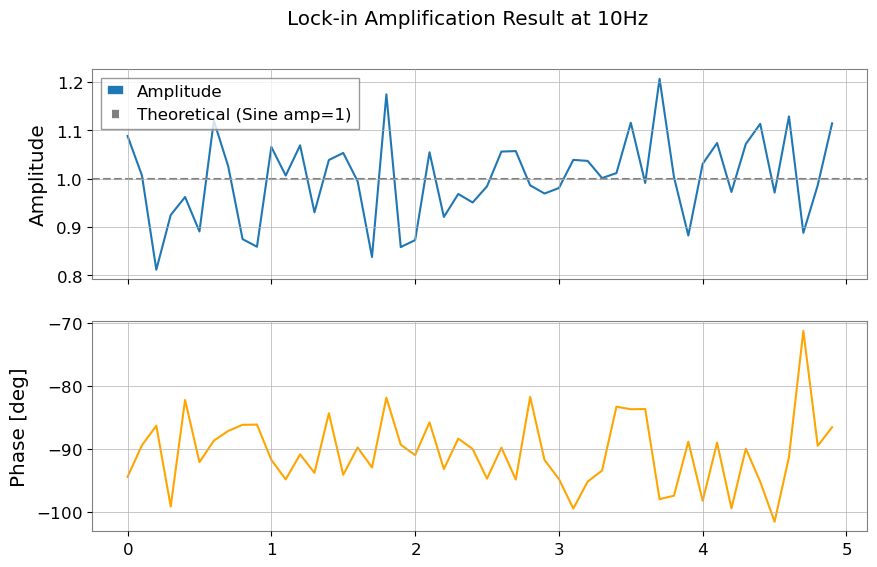

In [4]:
# 1. mix_down: 特定の周波数 f0 で複調 (複素信号になる)
ts_mixed = ts1.mix_down(f0=10)

# 2. baseband: demodulation + lowpass + resampling を一括実行
ts_base = ts1.baseband(f0=10, lowpass=5, output_rate=20)

# 3. lock_in: ロックイン検波 (振幅と位相を抽出)
amp, ph = ts1.lock_in(f0=10, stride=0.1) # 0.1秒ごとの平均を出力
res_complex = ts1.lock_in(f0=10, stride=0.1, output='complex') # 複素数での出力

display(amp)

fig, ax = plt.subplots(2, 1, figsize=(10, 6), sharex=True)
ax[0].plot(amp, label='Amplitude')
ax[0].axhline(1.0, color='gray', linestyle='--', label='Theoretical (Sine amp=1)')
ax[0].set_ylabel('Amplitude')
ax[0].legend()
ax[1].plot(ph, label='Phase [deg]', color='orange')
ax[1].set_ylabel('Phase [deg]')
plt.suptitle('Lock-in Amplification Result at 10Hz')
plt.show()

<a id="spectral"></a>
## 3. スペクトル解析と相関

GWpy の機能を継承しつつ、過渡信号向けの `transient` モード FFT や、FFT の直接比による伝達関数計算が追加されています。

### 拡張された FFT
`mode="transient"` を使用すると、ゼロパディングや高速な長さへの調整、左右個別のパディング指定が可能です。

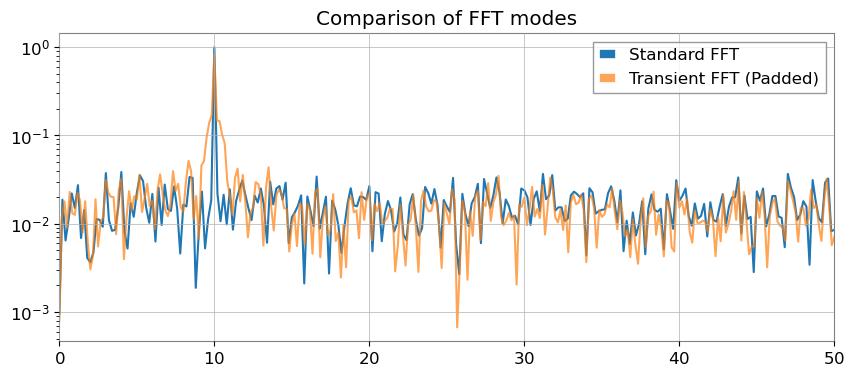

In [5]:
# 通常の FFT (GWpy互換)
fs_gwpy = ts1.fft()

# Transient モード: 
# pad_left/right でパディング量を指定。nfft_mode="next_fast_len" で計算効率の良い長さに調整。
fs_trans = ts1.fft(mode="transient", pad_left=0.5, pad_right=0.5, nfft_mode="next_fast_len")

plt.figure(figsize=(10, 4))
plt.semilogy(fs_gwpy.frequencies, np.abs(fs_gwpy), label='Standard FFT')
plt.semilogy(fs_trans.frequencies, np.abs(fs_trans), label='Transient FFT (Padded)', alpha=0.7)
plt.xlim(0, 50)
plt.legend()
plt.title('Comparison of FFT modes')
plt.show()

### 伝達関数 (Transfer Function) と相互相関 (xcorr)
`transfer_function` では Welch法 (`method="gwpy"`) だけでなく、FFT の直接比 (`method="fft"`) も選択できます。

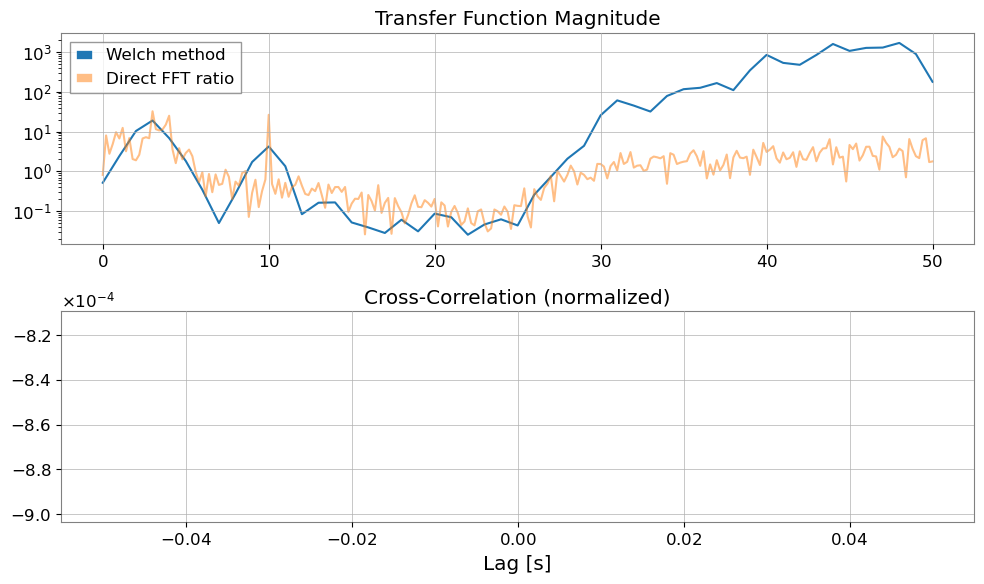

In [6]:
# 伝達関数の計算 (Sensor 1 に対する Chirp Signal の伝達関数)
tf_welch = ts2.transfer_function(ts1, fftlength=1)
tf_fft = ts2.transfer_function(ts1, method="fft") # 全区間FFT比 (過渡応答解析などに有用)

# 相互相関 (xcorr)
corr = ts1.xcorr(ts2, maxlag=0.5, normalize='coeff')

fig, ax = plt.subplots(2, 1, figsize=(10, 6))
ax[0].semilogy(tf_welch.frequencies, np.abs(tf_welch), label='Welch method')
ax[0].semilogy(tf_fft.frequencies, np.abs(tf_fft), label='Direct FFT ratio', alpha=0.5)
ax[0].set_title('Transfer Function Magnitude')
ax[0].legend()

lag = corr.times.value - corr.t0.value
ax[1].plot(lag, corr)
ax[1].set_title('Cross-Correlation (normalized)')
ax[1].set_xlabel('Lag [s]')
plt.tight_layout()
plt.show()

### STLT (Short-Time Local Transform)

STLT (Short-Time Local Transform) は、信号の時間変化に伴う局所的な構造（対称な2軸を持つ特徴量）を抽出するための変換です。
`gwexpy` では、このような3Dデータ (時間 x 軸1 x 軸2) を扱うために `TimePlaneTransform` クラスを提供しています。

以下は、`stlt` メソッドを使用して STLT を計算し、特定時刻のスライス (`Plane2D`) を抽出する例です。

In [7]:
# データの準備 (デモ用)
import numpy as np
from gwexpy.timeseries import TimeSeries
from astropy import units as u

t = np.linspace(0, 10, 1000)
data = TimeSeries(np.sin(2 * np.pi * 1 * t), times=t*u.s, unit='V', name='Demo Data')

# STLT の実行
# stride: 時間ステップ, window: 解析ウィンドウ長
stlt_result = data.stlt(stride='0.5s', window='2s')

print(f"Kind: {stlt_result.kind}")
print(f"Shape: {stlt_result.shape} (Time x Axis1 x Axis2)")
print(f"Time Axis: {len(stlt_result.times)} steps")

# 特定時刻 (t=5.0s) の平面を抽出
plane_at_5s = stlt_result.at_time(5.0 * u.s)
print(f"Plane at 5.0s shape: {plane_at_5s.shape}")

# Plane2D としての振る舞いを確認
print(f"Axis 1: {plane_at_5s.axis1.name}")
print(f"Axis 2: {plane_at_5s.axis2.name}")

Kind: stlt_mag_outer
Shape: (17, 101, 101) (Time x Axis1 x Axis2)
Time Axis: 17 steps
Plane at 5.0s shape: (101, 101)
Axis 1: axis1
Axis 2: axis2


## 4. Hilbert-Huang Transform (HHT)
非線形・非定常信号解析のためのヒルベルト・ファン変換 (HHT) 機能です。
Empirical Mode Decomposition (EMD) とヒルベルトスペクトル解析を組み合わせます。

Extracted IMFs: ['IMF1', 'IMF2', 'IMF3', 'residual']


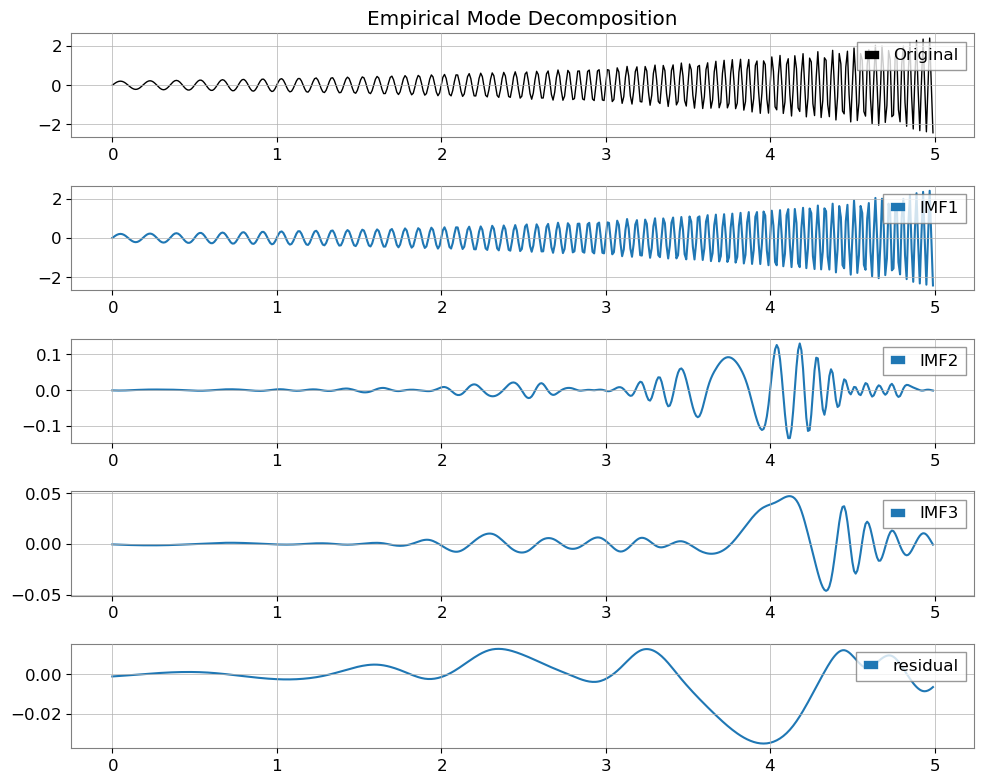

/home/washimi/mambaforge/lib/python3.10/site-packages/gwpy/types/series.py:131: UserWarning: xindex was given to Spectrogram(), x0 will be ignored
  warn("xindex was given to %s(), x0 will be ignored"
/home/washimi/mambaforge/lib/python3.10/site-packages/gwpy/plot/plot.py:296: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  super().show(warn=warn)


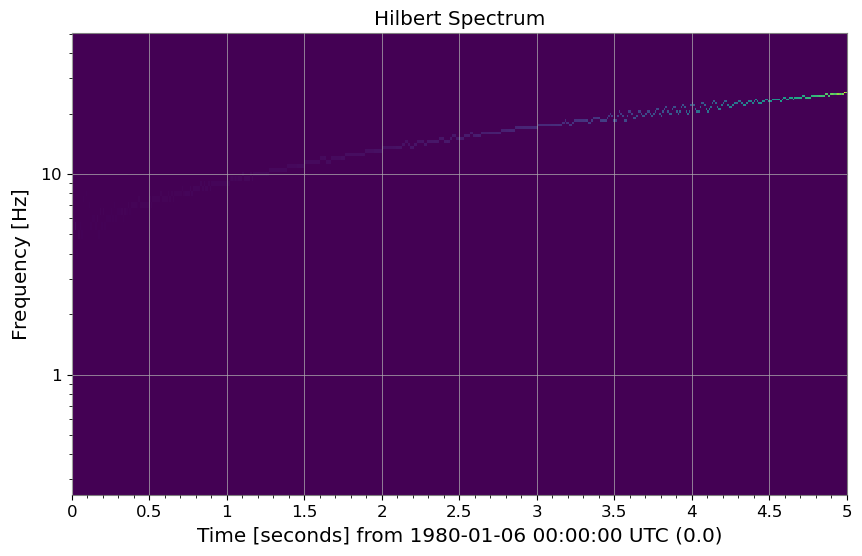

In [8]:
# HHT (Hilbert-Huang Transform)
# Empirical Mode Decomposition (EMD) を実行し、IMFs (Intrinsic Mode Functions) を抽出
# 注意: 実行には PyEMD (EMD-signal) が必要です: `pip install EMD-signal`

try:
    # EMDの実行 (戻り値は辞書)
    # method="emd" (標準EMD) または "eemd" (Ensemble EMD)
    # ここでは ts2 (Chirp信号を含む例) を使用します
    imfs = ts2.emd(method="emd", max_imf=3)
    
    print(f"Extracted IMFs: {list(imfs.keys())}")
    
    # IMFのプロット
    plt.figure(figsize=(10, 8))
    # Original
    plt.subplot(len(imfs)+1, 1, 1)
    plt.plot(ts2.times.value, ts2.value, label="Original", color='black', lw=1)
    plt.legend(loc="upper right")
    plt.title("Empirical Mode Decomposition")
    
    # IMFs
    sorted_keys = sorted([k for k in imfs.keys() if k.startswith("IMF")], key=lambda x: int(x[3:]))
    if "residual" in imfs:
        sorted_keys.append("residual")
        
    for j, key in enumerate(sorted_keys):
        imf = imfs[key]
        plt.subplot(len(imfs)+1, 1, j+2)
        plt.plot(imf.times.value, imf.value, label=key)
        plt.legend(loc="upper right")
        
    plt.tight_layout()
    plt.show()

    # HHTによるヒルベルトスペクトログラム
    # output="spectrogram" を指定すると Spectrogram オブジェクトが返る
    hht_spec = ts2.hht(emd_method="emd", output="spectrogram", emd_kwargs={"max_imf": 3})
    
    plot = hht_spec.plot(figsize=(10, 6))
    ax = plot.gca()
    ax.set_title("Hilbert Spectrum")
    ax.set_yscale("log")
    plot.show()

except ImportError:
    print("EMD-signal not installed. Skipping HHT demo.")
except Exception as e:
    print(f"HHT Error: {e}")



<a id="stats"></a>
## 5. 統計・前処理

欠損値補完、標準化、ARIMAモデル、ハースト指数、およびローリング統計量が TimeSeries メソッドとして利用可能です。

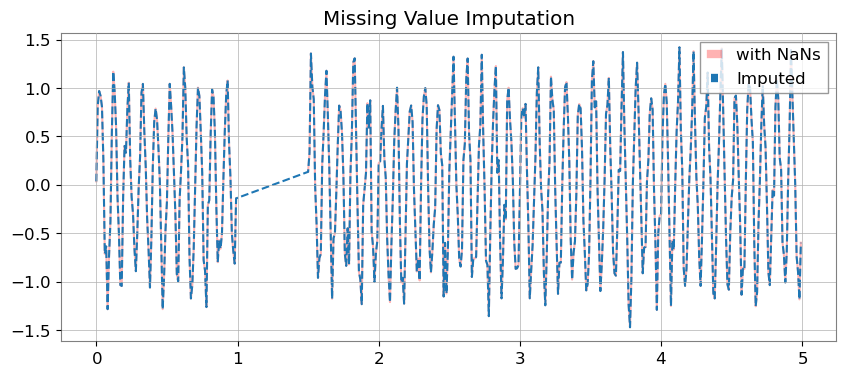

In [9]:
# 欠損値を含むデータのテスト
ts_nan = ts1.copy()
ts_nan.value[100:150] = np.nan

# 1. impute: 欠損値補完 (interpolation など)
ts_imputed = ts_nan.impute(method='interpolate')

# 2. standardize: 標準化 (z-score, robust など)
ts_z = ts1.standardize(method='zscore')
ts_robust = ts1.standardize(method='zscore', robust=True) # Median/IQRを使用

plt.figure(figsize=(10, 4))
plt.plot(ts_nan, label='with NaNs', color='red', alpha=0.3)
plt.plot(ts_imputed, label='Imputed', linestyle='--')
plt.legend()
plt.title('Missing Value Imputation')
plt.show()

### ピーク検出 (Find Peaks)
`scipy.signal.find_peaks` をラップし、時系列データからピークを検出します。

Found 9 peaks
First 5 peaks: TimeSeries([0.24297757, 0.33159257, 0.44513676, 0.58819005,
            0.77322212]
           unit: V,
           t0: 0.39 s,
           dt: None,
           name: Chirp Signal_peaks,
           channel: None)


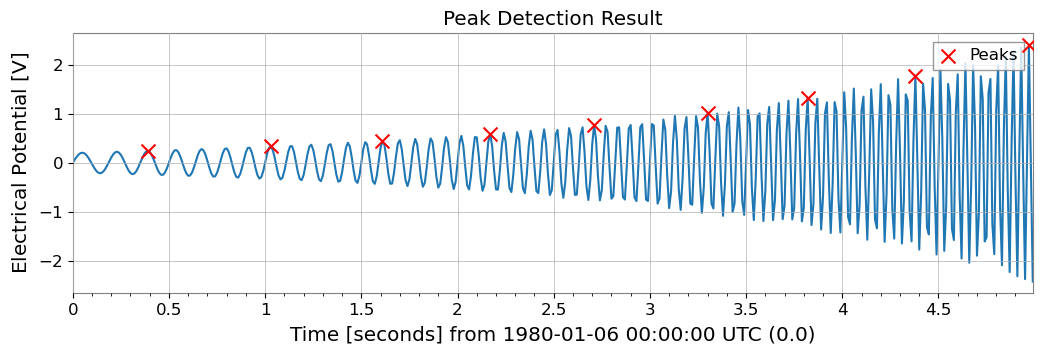

In [10]:
# ピーク検出 (Find Peaks)
# height, threshold, distance, prominence, width などのパラメータを指定可能
# 単位付きの閾値指定も可能です

# ts2 (Chirp + Sine) からピークを探す
peaks, props = ts2.find_peaks(height=0.0, distance=50) 

print(f"Found {len(peaks)} peaks")
if len(peaks) > 0:
    print("First 5 peaks:", peaks[:5])

# プロット
plot = ts2.plot(figsize=(12, 4))
ax = plot.gca()
ax.scatter(peaks.times.value, peaks.value, marker="x", color="red", s=100, label="Peaks", zorder=10)
ax.legend(loc="upper right")
ax.set_title("Peak Detection Result")
plot.show()



### ARIMAモデルとハースト指数
※ これらの機能には `statsmodels`, `hurst` 等のライブラリが必要です。

In [11]:
try:
    # 3. fit_arima: ARIMA(1,0,0) フィッティングと予測
    model = ts1.fit_arima(order=(1, 0, 0))
    resid = model.residuals()
    forecast, conf = model.forecast(steps=30)
    
    plt.figure(figsize=(10, 4))
    plt.plot(ts1.tail(100), label='Measured')
    plt.plot(forecast, label='Forecast', color='orange')
    plt.fill_between(conf['lower'].times.value, conf['lower'].value, conf['upper'].value, alpha=0.2, color='orange')
    plt.title('ARIMA(1,0,0) Fit & Forecast')
    plt.legend()
    plt.show()
except Exception as e:
    print(f"ARIMA skipping: {e}")

try:
    # 4. hurst / local_hurst: ハースト指数 (長距離相関の指標)
    h_val = ts1.hurst()
    h_detail = ts1.hurst(return_details=True) # 詳細情報付き
    h_local = ts1.local_hurst(window=1.0) # 1秒窓での推移
    
    plt.figure(figsize=(10, 4))
    plt.plot(h_local, label='Local Hurst')
    plt.axhline(h_val, color='red', linestyle='--', label=f'Global H={h_val:.2f}')
    plt.ylim(0, 1)
    plt.title('Hurst Exponent Analysis')
    plt.legend()
    plt.show()
except Exception as e:
    print(f"Hurst skipping: {e}")

ARIMA skipping: 'TimeSeries' object has no attribute 'tail'
Hurst skipping: No Hurst backend found. Install hurst, hurst-exponent, or exp-hurst.


<Figure size 1000x400 with 0 Axes>

### ローリング統計量 (Rolling Statistics)
Pandas と同様の使い勝手で、`rolling_mean`, `std`, `median`, `min`, `max` が利用できます。

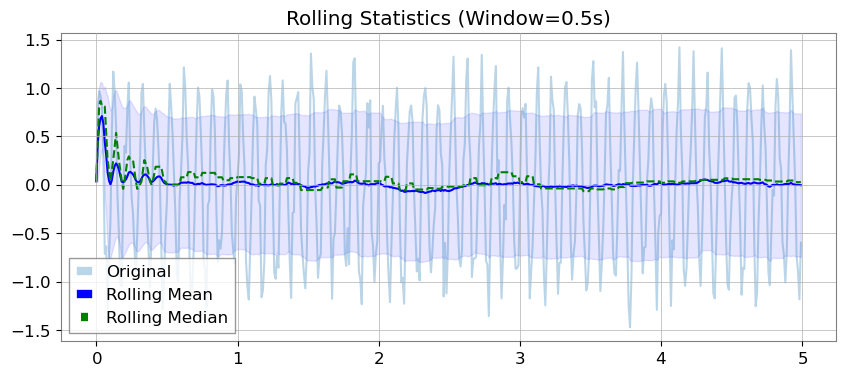

In [12]:
rw = 0.5 * u.s # 0.5秒窓
rmean = ts1.rolling_mean(rw)
rstd = ts1.rolling_std(rw)
rmed = ts1.rolling_median(rw)
rmin = ts1.rolling_min(rw)
rmax = ts1.rolling_max(rw)

plt.figure(figsize=(10, 4))
plt.plot(ts1, alpha=0.3, label='Original')
plt.plot(rmean, label='Rolling Mean', color='blue')
plt.plot(rmed, label='Rolling Median', color='green', linestyle='--')
plt.fill_between(rmean.times.value, rmean.value - rstd.value, rmean.value + rstd.value, alpha=0.1, color='blue')
plt.legend()
plt.title('Rolling Statistics (Window=0.5s)')
plt.show()

<a id="resampling"></a>
## 6. リサンプリングと再インデックス

`asfreq` メソッドによる固定グリッドへの割り当てや、`resample` メソッドでの「時間ビン集計」が可能になりました。

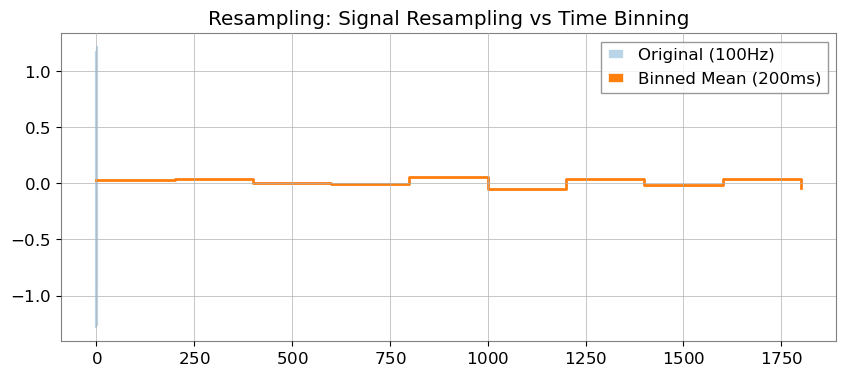

In [13]:
# 1. asfreq: Pandasライクな名付け規則 ('50ms' など) で再インデックス
ts_reindexed = ts1.asfreq('50ms', method='pad')

# 2. resample: 
# 数値 (10Hz) を指定すると信号処理的なリサンプリング (GWpy標準)
ts_sig = ts1.resample(10)
# 文字列 ('200ms') を指定すると、その時間幅のビンごとの統計量をとる (新機能)
ts_binned = ts1.resample('200ms') # デフォルトは mean

plt.figure(figsize=(10, 4))
plt.step(ts1.times.value[:100], ts1.value[:100], alpha=0.3, label='Original (100Hz)')
plt.step(ts_binned.times.value[:10], ts_binned.value[:10], where='post', label='Binned Mean (200ms)', linewidth=2)
plt.legend()
plt.title('Resampling: Signal Resampling vs Time Binning')
plt.show()

<a id="interop"></a>
## 7. 相互運用性

主要なデータサイエンス・機械学習ライブラリとの相互変換が非常にスムーズです。

In [14]:
# Pandas & Xarray
df = ts1.to_pandas(index='datetime')
display(df.head())
ts_p = TimeSeries.from_pandas(df)

try:
    xr = ts1.to_xarray()
    ts_xr = TimeSeries.from_xarray(xr)
    print("Xarray interop OK")
except ImportError: pass

# SQLite (シリアライズ保存)
import sqlite3
with sqlite3.connect(':memory:') as conn:
    ts1.to_sqlite(conn, series_id='my_sensor')
    ts_sql = TimeSeries.from_sqlite(conn, series_id='my_sensor')
    print(f"SQLite interop OK: {ts_sql.name}")

# Deep Learning (Torch, TF, JAX)
try:
    import torch
    t_torch = ts1.to_torch()
    ts_f_torch = TimeSeries.from_torch(t_torch, t0=ts1.t0, dt=ts1.dt)
    print(f"Torch interop OK (Shape: {t_torch.shape})")
except ImportError: pass

try:
    import tensorflow as tf
    t_tf = ts1.to_tf()
    ts_f_tf = TimeSeries.from_tf(t_tf, t0=ts1.t0, dt=ts1.dt)
    print("TensorFlow interop OK")
except ImportError: pass

# ObsPy (地震波形・時系列解析)
try:
    import obspy
    tr = ts1.to_obspy_trace()
    ts_f_obspy = TimeSeries.from_obspy_trace(tr)
    print(f"ObsPy interop OK: {tr.id}")
except ImportError: pass

# HDF5 / Zarr / netCDF4 / Dask (クラウド・大規模データ)
try:
    import h5py
    with h5py.File('demo.h5', 'w') as f:
        ts1.to_hdf5_dataset(f, 'group/timeseries')
    with h5py.File('demo.h5', 'r') as f:
        ts_h5 = TimeSeries.from_hdf5_dataset(f, 'group/timeseries')
        print("HDF5 interop OK")
except (ImportError, OSError): pass

print("他にも Dask (to_dask), Zarr (to_zarr), netCDF4 (to_netcdf4), CuPy (to_cupy), JAX (to_jax), Librosa (to_librosa), Pydub (to_pydub) などに対応しています。")

time_utc
1980-01-06 00:00:19+00:00           0.035923
1980-01-06 00:00:19.010000+00:00    0.815854
1980-01-06 00:00:19.020000+00:00    0.968728
1980-01-06 00:00:19.030000+00:00    0.919361
1980-01-06 00:00:19.040000+00:00    0.807316
Name: Sensor 1, dtype: float64

Xarray interop OK
SQLite interop OK: my_sensor
Torch interop OK (Shape: torch.Size([500]))


2025-12-19 19:06:54.804148: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-12-19 19:06:54.862849: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


TensorFlow interop OK
ObsPy interop OK: ...
HDF5 interop OK
他にも Dask (to_dask), Zarr (to_zarr), netCDF4 (to_netcdf4), CuPy (to_cupy), JAX (to_jax), Librosa (to_librosa), Pydub (to_pydub) などに対応しています。


2025-12-19 19:06:56.685410: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


### まとめ

`gwexpy` の `TimeSeries` クラスは、従来の GWpy の使い勝手はそのままに、より現代的で広範な分析ニーズに応える機能を備えています。
是非、皆さんのプロジェクトで活用してください！